Data ready.
Nets ready.
Beginning training.
10 epochs passed.
20 epochs passed.
30 epochs passed.
40 epochs passed.
Training finished.

Summary of training


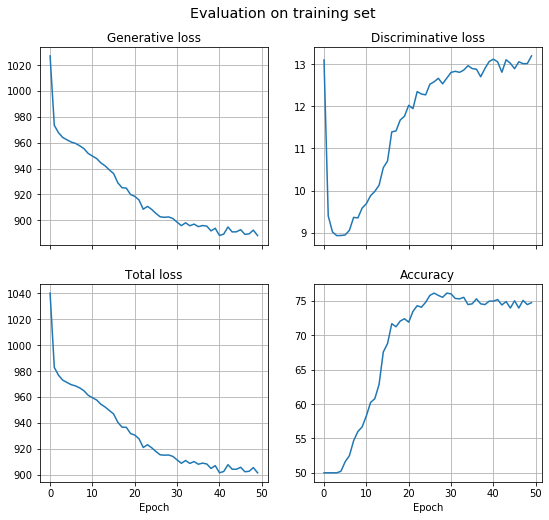

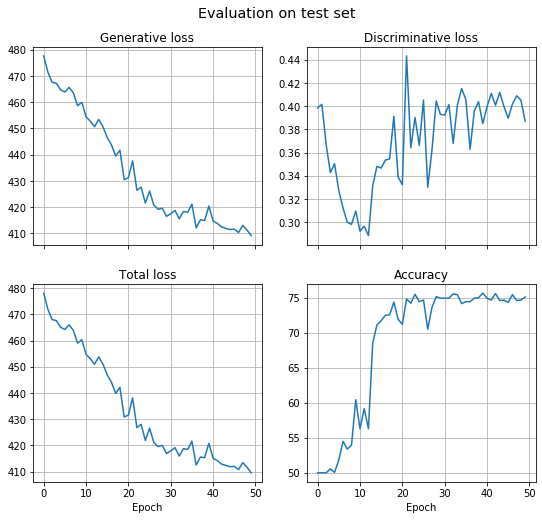

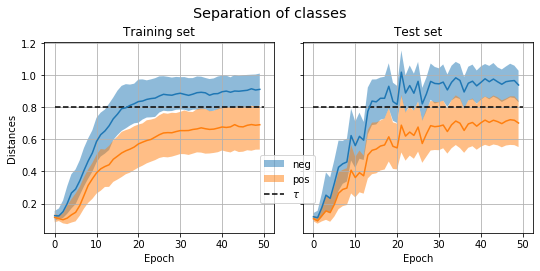

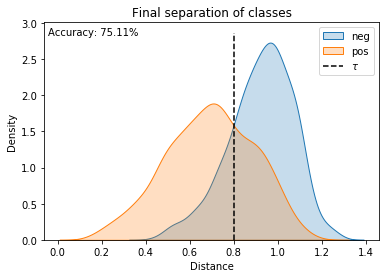

In [1]:
import itertools as it

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from seven.mnist import DiscriminativeSNN, GenerativeSNN
from criterions import ModifiedCrossEntropy, ReconstructionLoss, ContrastiveLoss
from data import SiameseMNIST as Dataset


device = "cuda" if torch.cuda.is_available() else "cpu"

# load data and prepare it
dataset = Dataset()

use_unlabeled = True # whether to use unlabeled examples
dataset.sample_traintest()
if use_unlabeled:
    dataset.sample_unlabeled(10)

batch_size = 60
positive = torch.utils.data.DataLoader(dataset.positive, batch_size=batch_size // 2, shuffle=True)
negative = torch.utils.data.DataLoader(dataset.negative, batch_size=batch_size // 2, shuffle=True)
if use_unlabeled:
    unlabeled = torch.utils.data.DataLoader(dataset.unlabeled, batch_size=batch_size, shuffle=True)
else:
    unlabeled = [None for _ in range(len(dataset.trainset) // batch_size)]

testset = torch.utils.data.DataLoader(dataset.testset, batch_size=len(dataset.testset))
print("Data ready.")

# initialize nets and optimizers
net1, net2 = DiscriminativeSNN().to(device), GenerativeSNN().to(device)
# criterion1 = ModifiedCrossEntropy()
criterion1 = ContrastiveLoss(margin=1.0)
criterion2 = ReconstructionLoss()
alpha = 0.005  # importance of reconstruction loss
beta = 0.1 # l2 regularization
lr = 0.001  # learning rate
parameters = [{"params": net1.parameters()}, {"params": net2.parameters()}]
optimizer = torch.optim.RMSprop(parameters, lr=lr, weight_decay=beta)
print("Nets ready.")

# training parameters
T = 0.8  # threshold
E = 50 # epochs

# for diagnostics
train_log = {
    "discriminative_loss": [],  # discriminative part of loss
    "generative_loss": [],  # generative part of loss
    "total_loss": [],  # total loss
    "accuracy": [],  # accuracy
    "pos_dists": [],  # predicted distances between positive pairs
    "neg_dists": [],  # predicted distances between negative pairs
}

test_log = {
    "discriminative_loss": [],
    "generative_loss": [],
    "total_loss": [],
    "accuracy": [],
    "pos_dists": [],
    "neg_dists": [],
}

# training
print("Beginning training.")
for i in range(E):
    if i != 0 and i % 10 == 0:
        print(f"{i} epochs passed.")

    # for plots
    train_log["discriminative_loss"].append(0.0)
    train_log["generative_loss"].append(0.0)
    train_log["total_loss"].append(0.0)
    train_log["accuracy"].append([0, 0])
    train_log["pos_dists"].append([])
    train_log["neg_dists"].append([])

    # actual training
    for pos, neg, unlab in zip(it.cycle(positive), it.cycle(negative), unlabeled):
        optimizer.zero_grad()

        ## labeled data
        imgs1, imgs2, labs = pos
        imgs1_, imgs2_, labs_ = neg
        images1 = torch.cat([imgs1, imgs1_], dim=0).to(device)
        images2 = torch.cat([imgs2, imgs2_], dim=0).to(device)
        labels = torch.cat([labs, labs_], dim=0).to(device)

        # first net
        outputs1, outputs2 = net1(images1, images2)
        loss1 = criterion1(outputs1, outputs2, labels)

        # second net
        images1_, images2_ = net2(outputs1, outputs2)
        loss2 = criterion2(images1, images1_) + criterion2(images2, images2_)

        # final loss
        loss = loss1 + alpha * loss2

        # for plots
        train_log["discriminative_loss"][-1] += loss1.item()
        train_log["generative_loss"][-1] += alpha * loss2.item()

        # evaluation on training set
        net1.eval()
        with torch.no_grad():
            outputs1, outputs2 = net1(images1, images2)
            dists = F.pairwise_distance(outputs1, outputs2)
            preds = (dists <= T).float()
            train_log["accuracy"][-1][0] += len(preds)
            train_log["accuracy"][-1][1] += (
                torch.isclose(labels.squeeze(), preds).sum().item()
            )

            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    train_log["pos_dists"][-1].append(dist.item())
                else:
                    train_log["neg_dists"][-1].append(dist.item())
        net1.train()

        if use_unlabeled: ## unlabeled data
            images1, images2 = (t.to(device) for t in unlab)

            # first net
            outputs1, outputs2 = net1(images1, images2)

            # second net
            images1_, images2_ = net2(outputs1, outputs2)
            loss2 = criterion2(images1, images1_) + criterion2(images2, images2_)

            # total loss
            loss += alpha * loss2

            # for plots
            train_log["generative_loss"][-1] += alpha * loss2.item()

        ## for plots
        train_log["total_loss"][-1] += loss.item()

        ## step
        loss.backward()
        optimizer.step()

    # for plots
    train_log["accuracy"][-1] = (
        100 * train_log["accuracy"][-1][1] / train_log["accuracy"][-1][0]
    )

    test_log["discriminative_loss"].append(0.0)
    test_log["generative_loss"].append(0.0)
    test_log["total_loss"].append(0.0)
    test_log["accuracy"].append(0.0)
    test_log["pos_dists"].append([])
    test_log["neg_dists"].append([])

    # evaluation on test set
    net1.eval()
    net2.eval()
    with torch.no_grad():
        for tensors in testset:
            images1, images2, labels = (t.to(device) for t in tensors)
            outputs1, outputs2 = net1(images1, images2)
            images1_, images2_ = net2(outputs1, outputs2)

            loss1 = criterion1(outputs1, outputs2, labels)
            loss2 = criterion2(images1, images1_) + criterion2(images2, images2_)
            loss = loss1 + alpha * loss2

            test_log["discriminative_loss"][-1] += loss1.item()
            test_log["generative_loss"][-1] += alpha * loss2.item()
            test_log["total_loss"][-1] += loss.item()

            dists = F.pairwise_distance(outputs1, outputs2)
            preds = (dists <= T).float()

            test_log["accuracy"][-1] += (
                torch.isclose(labels.squeeze(), preds).sum().item()
            )

            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    test_log["pos_dists"][-1].append(dist.item())
                else:
                    test_log["neg_dists"][-1].append(dist.item())
    test_log["accuracy"][-1] /= len(dataset.testset) / 100
    net1.train()
    net2.train()

print("Training finished.\n")

# summary - training
print("Summary of training")
start = 0  # the first epoch to be taken into consideration
domain = range(start, E)
ticks = list(range(start, E + 1, (E - start) // 5)) 

train_pos_dists = np.array(train_log["pos_dists"][start:])
train_neg_dists = np.array(train_log["neg_dists"][start:])
test_pos_dists = np.array(test_log["pos_dists"][start:])
test_neg_dists = np.array(test_log["neg_dists"][start:])

# on training set
fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharex=True)
fig.suptitle("Evaluation on training set", y=0.95, fontsize="x-large")

axs[0, 0].plot(domain, train_log["generative_loss"][start:])
axs[0, 0].set(title="Generative loss", xticks=ticks)
axs[0, 0].grid()

axs[0, 1].plot(domain, train_log["discriminative_loss"][start:])
axs[0, 1].set(title="Discriminative loss", xticks=ticks)
axs[0, 1].grid()

axs[1, 0].plot(domain, train_log["total_loss"][start:])
axs[1, 0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
axs[1, 0].grid()

axs[1, 1].plot(domain, train_log["accuracy"][start:])
axs[1, 1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
axs[1, 1].grid()

plt.show()

# on test set
fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharex=True)
fig.suptitle("Evaluation on test set", y=0.95, fontsize="x-large")

axs[0, 0].plot(domain, test_log["generative_loss"][start:])
axs[0, 0].set(title="Generative loss", xticks=ticks)
axs[0, 0].grid()

axs[0, 1].plot(domain, test_log["discriminative_loss"][start:])
axs[0, 1].set(title="Discriminative loss", xticks=ticks)
axs[0, 1].grid()

axs[1, 0].plot(domain, test_log["total_loss"][start:])
axs[1, 0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
axs[1, 0].grid()

axs[1, 1].plot(domain, test_log["accuracy"][start:])
axs[1, 1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
axs[1, 1].grid()

plt.show()

# separation of classes throughout training
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.suptitle("Separation of classes", fontsize="x-large")

axs[0].set(title="Training set", xlabel="Epoch", ylabel="Distances", xticks=ticks)
axs[0].grid()

q25, q50, q75 = np.percentile(train_neg_dists, [25, 50, 75], axis=1)
axs[0].plot(domain, q50)
axs[0].fill_between(domain, q75, q25, alpha=0.5, label="neg")

q25, q50, q75 = np.percentile(train_pos_dists, [25, 50, 75], axis=1)
axs[0].plot(domain, q50)
axs[0].fill_between(domain, q75, q25, alpha=0.5, label="pos")

axs[0].hlines(T, start, E, label="$\\tau$", linestyles="--")

axs[1].set(title="Test set", xlabel="Epoch", xticks=ticks)
axs[1].grid()

q25, q50, q75 = np.percentile(test_neg_dists, [25, 50, 75], axis=1)
axs[1].plot(domain, q50)
axs[1].fill_between(domain, q75, q25, alpha=0.5)

q25, q50, q75 = np.percentile(test_pos_dists, [25, 50, 75], axis=1)
axs[1].plot(domain, q50)
axs[1].fill_between(domain, q75, q25, alpha=0.5)

axs[1].hlines(T, start, E, linestyles="--")

fig.tight_layout(pad=2.5)
fig.legend(loc=(0.482, 0.25))

plt.show()

# final model
plt.title("Final separation of classes")
sns.kdeplot(test_log["neg_dists"][-1], fill=True, label="neg")
sns.kdeplot(test_log["pos_dists"][-1], fill=True, label="pos")
plt.vlines(T, 0, plt.gca().get_ylim()[1], linestyles="--", label="$\\tau$")
plt.text(
    0.01,
    0.94,
    f"Accuracy: {test_log['accuracy'][-1]:.2f}%",
    transform=plt.gca().transAxes,
)
plt.xlabel("Distance")
plt.legend()
plt.show()

# best = np.argmax(test_log["accuracy"])
# plt.title(f"Separation of classes in the best model (epoch {best})")
# sns.kdeplot(test_log["neg_dists"][best], fill=True, label="neg")
# sns.kdeplot(test_log["pos_dists"][best], fill=True, label="pos")
# plt.vlines(T, 0, plt.gca().get_ylim()[1], linestyles="--", label="$\\tau$")
# plt.text(
#     0.01,
#     0.94,
#     f"Accuracy: {test_log['accuracy'][best]:.2f}%",
#     transform=plt.gca().transAxes,
# )
# plt.xlabel("Distance")
# plt.legend()
# plt.show()
